# Mask RCNN Fine-Tuning Implementation File

In this file we have attempted to fine Tune a pretrained MaskRCNN with a ResNet50 backbone.\
First we load the ptretrained model, and do CoCO Eval on 1000 images.\
Later we experiment different methods to fine tune the model and compare its result with the pretrained Model.\
We have tried to make the code modular, and using this notebook one can easily load and fine tune pretrained RCNN model, train and evaluate it with CoCo style dataset. More details can be found in the ReadME.md


Sources:
1) Paper: https://arxiv.org/abs/1703.06870 
2) Pytorch Documentation: https://pytorch.org/vision/stable/models/generated/torchvision.models.detection.maskrcnn_resnet50_fpn.html  



Note: Generative AI was used for coding assistance and debugging

In [1]:
#Imports
import torch
import torchvision
from torchvision import models
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from pycocotools.coco import COCO
import numpy as np
from torchvision import transforms
from PIL import Image
from collections import defaultdict
import os
import random
import matplotlib.pyplot as plt
import cv2
from pycocotools.cocoeval import COCOeval
import json
from pycocotools import mask as maskUtils  
from torch.utils.data import DataLoader



In [2]:
# Define paths
coco_root = "/var/lit2425/pib/g10/CoCo"
coco_train_annotations = f"{coco_root}/annotations/instances_train2017.json"
coco_train_images = f"{coco_root}/train2017"
coco_val_annotations = f"{coco_root}/annotations/instances_val2017.json"
coco_val_images = f"{coco_root}/val2017"

# Load COCO dataset annotations
coco = COCO(coco_val_annotations)
image_ids = coco.getImgIds()

#Checking number of images in directory
print(f"Number of images in COCO validation set: {len(image_ids)}")

loading annotations into memory...
Done (t=0.27s)
creating index...
index created!
Number of images in COCO validation set: 5000


### Helper Functions

In [15]:
# Image preprocessing
transform = transforms.Compose([transforms.ToTensor()])

# IoU Calculation Function
def calculate_mask_iou(maskA, maskB):
    
    intersection = np.logical_and(maskA, maskB)
    union = np.logical_or(maskA, maskB)
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0
    return iou




In [16]:
# Load pretrained Mask R-CNN model
def load_pretrained_maskrcnn():
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    print("Pretrained Mask R-CNN model loaded.")
    return model, device


# Image preprocessing
transform = transforms.Compose([transforms.ToTensor()])

# Load pretrained Mask R-CNN model
model, device = load_pretrained_maskrcnn()

Pretrained Mask R-CNN model loaded.


In [5]:
# Mask detection function
def detect_masks(image_path, model, transform, score_threshold=0.5):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        predictions = model(image_tensor)[0]

    pred_masks = predictions['masks'].cpu().numpy()
    pred_classes = predictions['labels'].cpu().tolist()
    pred_scores = predictions['scores'].cpu().tolist()

    # Filter out low-confidence detections
    filtered_preds = [(mask, cls, score) for mask, cls, score in zip(pred_masks, pred_classes, pred_scores) if score > score_threshold]
    
    if not filtered_preds:
        return [], [], []
    
    pred_masks, pred_classes, pred_scores = zip(*filtered_preds)
    return pred_masks, pred_classes, pred_scores


In [ ]:
# Compute metrics for segmentation masks
def compute_mask_metrics(N=1000, score_threshold=0.5):
    coco_results = []
    iou_scores = []  # To store IoU scores for each image
    
    for img_id in image_ids[:N]:
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(coco_val_images, img_info['file_name'])

        annotation_ids = coco.getAnnIds(imgIds=img_id)
        annotations = coco.loadAnns(annotation_ids)

        # Get ground truth masks
        gt_masks = [coco.annToMask(ann) for ann in annotations]
        gt_classes = [ann['category_id'] for ann in annotations]

        # Get model predictions
        pred_masks, pred_classes, pred_scores = detect_masks(img_path, model, transform, score_threshold)

        # Calculate IoU for each predicted mask
        for pred_mask, pred_cls in zip(pred_masks, pred_classes):
            # Find the corresponding ground truth mask for the predicted class
            gt_mask = None
            for gt_mask_candidate, gt_cls in zip(gt_masks, gt_classes):
                if gt_cls == pred_cls:
                    gt_mask = gt_mask_candidate
                    break
            
            if gt_mask is not None:
                pred_mask_binary = pred_mask[0] > 0.5
                iou = calculate_mask_iou(gt_mask, pred_mask_binary)
                iou_scores.append(iou)

        # Format predictions for COCO evaluation
        for mask, cls, score in zip(pred_masks, pred_classes, pred_scores):
            # Convert mask to RLE format for COCO evaluation
            rle = maskUtils.encode(np.asfortranarray(mask[0] > 0.5))  # Binary mask
            rle['counts'] = rle['counts'].decode('utf-8')  # Convert bytes to string
            coco_results.append({
                "image_id": img_id,
                "category_id": cls,
                "segmentation": rle,
                "score": score
            })

    # Compute mAP for segmentation masks using COCO API
    with open("coco_mask_results.json", "w") as f:
        json.dump(coco_results, f)

    coco_dt = coco.loadRes("coco_mask_results.json")
    coco_eval = COCOeval(coco, coco_dt, "segm")  # Use "segm" for segmentation evaluation
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    map_50 = coco_eval.stats[1]  # AP @ IoU=0.50
    map_50_95 = coco_eval.stats[0]  # AP @ IoU=0.50:0.95

    # Calculate mean IoU
    mean_iou = np.mean(iou_scores) if iou_scores else 0

    # Print results
    print(f" Evaluated {N} images")
    print(f" mAP@50 (Segmentation): {map_50:.3f}")
    print(f" mAP@[0.5:0.95] (Segmentation): {map_50_95:.3f}")
    print(f" Mean IoU (Segmentation): {mean_iou:.3f}")

In [7]:
# Visualization function for segmentation masks
def visualize_masks(image_path, model, transform, score_threshold=0.5):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    pred_masks, pred_classes, pred_scores = detect_masks(image_path, model, transform, score_threshold)

    # Get COCO category names
    coco_categories = coco.loadCats(coco.getCatIds())
    category_names = {cat['id']: cat['name'] for cat in coco_categories}

    # Create a colormap for different objects
    colormap = plt.cm.get_cmap('tab20', len(pred_classes))

    # Create a pale white background
    background = np.full_like(image_rgb, (255, 255, 255))  # Pale white background

    for i, (mask, cls, score) in enumerate(zip(pred_masks, pred_classes, pred_scores)):
        # Overlay mask
        mask = mask[0]  # Remove batch dimension
        mask = (mask > 0.5).astype(np.uint8)
        color = np.array(colormap(i)[:3]) * 255  # Get RGB color from colormap
        mask_rgb = np.zeros_like(image_rgb)
        mask_rgb[:, :, 0] = mask * color[0]  # Red channel
        mask_rgb[:, :, 1] = mask * color[1]  # Green channel
        mask_rgb[:, :, 2] = mask * color[2]  # Blue channel

        # Combine the mask with the background
        background = np.where(mask[..., None] == 1, mask_rgb, background)

        # Add class name and score text
        class_name = category_names.get(cls, "Unknown")
        text = f"{class_name} | Score: {score:.2f}"
        

    plt.imshow(background)
    plt.axis("off")
    plt.show()



In [8]:
# Function to Load Fine Tuned Model
def load_finetuned_maskrcnn(checkpoint_path):
    # Start from PRETRAINED model (crucial!)
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)
    
    # Modify heads for COCO classes (91 classes)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, 91)
    
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
        in_features_mask, 256, 91
    )
    
    # Load fine-tuned weights
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))    
    model.to(device).eval()
    print(f"Loaded fine-tuned model from {checkpoint_path}")
    return model, device




### Evaluation of Pretrained Model of 1k images

Pretrained Mask R-CNN model loaded.
Loading and preparing results...
DONE (t=0.17s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=3.26s).
Accumulating evaluation results...
DONE (t=0.58s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.074
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.117
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.102
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.055
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.084
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.086
 Average Recall     (AR) @[ IoU=

/tmp/ipykernel_1269059/1906275827.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab20', len(pred_classes))


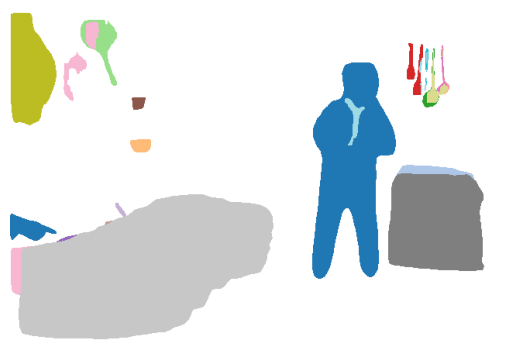

In [18]:
# Load pretrained Mask R-CNN model
model, device = load_pretrained_maskrcnn()
# Run Evaluation
compute_mask_metrics(N=1000, score_threshold=0.5)

first_img_id = image_ids[0]
first_img_info = coco.loadImgs(first_img_id)[0]
first_img_path = os.path.join(coco_val_images, first_img_info['file_name'])

visualize_masks(first_img_path, model, transform, score_threshold=0.5)

##### Here is the result of our best fine tuned model for comparison

Loaded fine-tuned model from mask_rcnn_mask_predictor_finetuned_10K_10epochs.pth
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=3.50s).
Accumulating evaluation results...
DONE (t=0.58s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.075
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.117
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.036
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.102
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.055
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.084
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1

/tmp/ipykernel_1269059/1906275827.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab20', len(pred_classes))


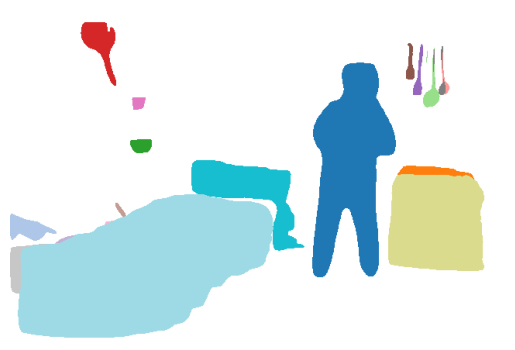

In [19]:
model, device = load_finetuned_maskrcnn(checkpoint_path="mask_rcnn_mask_predictor_finetuned_10K_10epochs.pth")
compute_mask_metrics(N=1000, score_threshold=0.5)

first_img_id = image_ids[0]
first_img_info = coco.loadImgs(first_img_id)[0]
first_img_path = os.path.join(coco_val_images, first_img_info['file_name'])

visualize_masks(first_img_path, model, transform, score_threshold=0.5)

### Fine Tuning ROI Head (Mask + Box) + RPN

In [9]:
# Define COCO dataset class
class COCODataset(torch.utils.data.Dataset):
    def __init__(self, coco, root, transform, subset_size=1000, seed=40):
        self.coco = coco
        self.root = root
        self.transform = transform
        
        all_image_ids = coco.getImgIds()
        random.seed(seed)
        sampled_ids = random.sample(all_image_ids, subset_size)
        
        self.image_ids = []
        for img_id in sampled_ids:
            ann_ids = coco.getAnnIds(imgIds=img_id)
            if len(ann_ids) > 0:
                self.image_ids.append(img_id)
        
        print(f"Subset: {len(self.image_ids)}/{subset_size} images have annotations.")
        if len(self.image_ids) == 0:
            raise ValueError("No valid images in subset!")
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root, img_info['file_name'])
        
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        
        # Filter out invalid bounding boxes
        valid_anns = [ann for ann in anns if ann['bbox'][2] > 0 and ann['bbox'][3] > 0]
        
        target = {}
        target['boxes'] = torch.tensor(
            [[x, y, x + w, y + h] for ann in valid_anns for x, y, w, h in [ann['bbox']]], 
            dtype=torch.float32
        )
        target['labels'] = torch.tensor(
            [ann['category_id'] for ann in valid_anns],
            dtype=torch.int64
        )
        target['masks'] = torch.tensor(
            np.stack([self.coco.annToMask(ann) for ann in valid_anns], axis=0),
            dtype=torch.uint8
        )
        
        return image, target

#### Training Pipeline

In [13]:
#Load PreTrained Model with frozen parameters 
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# Modify RoI heads for 91 classes
num_classes = 91   
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Modify mask predictor for 91 classes
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
    in_features_mask, hidden_layer, num_classes
)

# Freeze backbone and RPN
for param in model.backbone.parameters():
    param.requires_grad = False
for param in model.rpn.parameters():
    param.requires_grad = True

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
# Load COCO dataset
coco = COCO(coco_train_annotations)
dataset = COCODataset(coco, coco_train_images, transform, subset_size=1000)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))

# Test DataLoader
print("Testing DataLoader...")
for batch in dataloader:
    print("Successfully loaded a batch!")
    break
# Define optimizer (only trainable parameters)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.000001)

# Train for 5 epochs
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, targets in dataloader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.4f}")

# Save fine-tuned model
torch.save(model.state_dict(), "mask_rcnn_roi_subset1000.pth")
print("Training complete. Model saved.")

#### Adding More Data (1000->5000)

In [ ]:

# Load pretrained Mask R-CNN model
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# Modify RoI heads for 91 classes
num_classes = 91   
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Modify mask predictor for 91 classes
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
    in_features_mask, hidden_layer, num_classes
)

# Freeze backbone and RPN
for param in model.backbone.parameters():
    param.requires_grad = False
for param in model.rpn.parameters():
    param.requires_grad = True

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

        
# Load COCO dataset
coco = COCO(coco_train_annotations)
dataset = COCODataset(coco, coco_train_images, transform, subset_size=5000)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))

# Test DataLoader
print("Testing DataLoader...")
for batch in dataloader:
    print("Successfully loaded a batch!")
    break

# Define optimizer (only trainable parameters)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.000001)

# Train for 5 epochs
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, targets in dataloader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.4f}")

# Save fine-tuned model
torch.save(model.state_dict(), "mask_rcnn_roi_subset5000.pth")
print("Training complete. Model saved.")        

loading annotations into memory...
Done (t=6.89s)
creating index...
index created!
Subset: 4953/5000 images have annotations.
Testing DataLoader...
Successfully loaded a batch!
Epoch 1/5, Loss: 3.4495
Epoch 2/5, Loss: 2.1204
Epoch 3/5, Loss: 1.8915
Epoch 4/5, Loss: 1.7699
Epoch 5/5, Loss: 1.6691
Training complete. Model saved.


loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
Loaded fine-tuned model from mask_rcnn_roi_subset5000.pth
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=2.30s).
Accumulating evaluation results...
DONE (t=0.47s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.001
 Averag

/tmp/ipykernel_2212016/3803507283.py:95: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab20', len(masks))


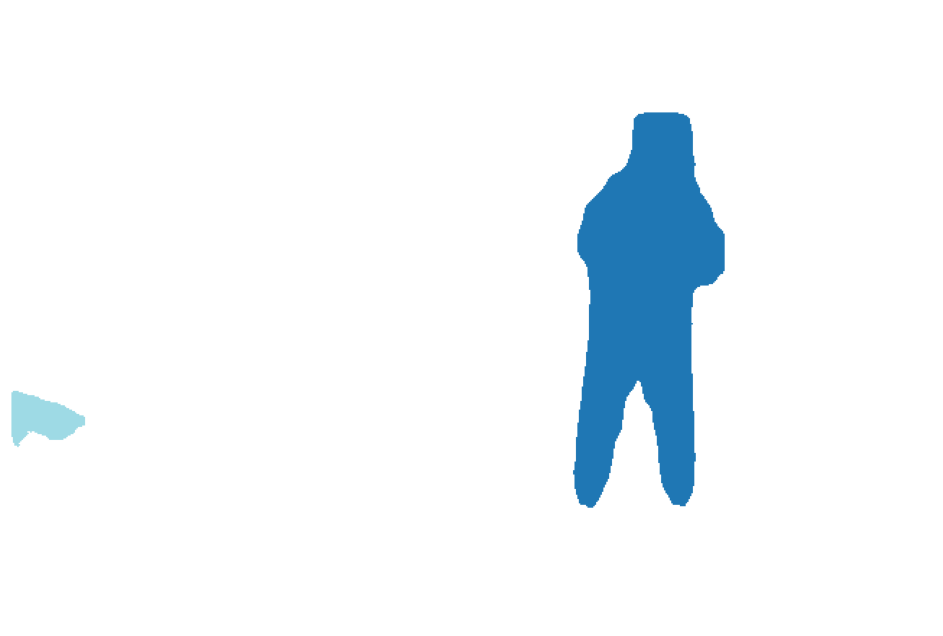

In [30]:
# Initialize
coco = COCO(coco_val_annotations)
image_ids = coco.getImgIds()
transform = transforms.Compose([transforms.ToTensor()])

# Load fine-tuned model
model, device = load_finetuned_maskrcnn(checkpoint_path="mask_rcnn_roi_subset5000.pth")


# Run evaluation
compute_mask_metrics(N=1000)

# Visualize results
first_img_id = image_ids[0]
first_img_path = os.path.join(coco_val_images, 
                            coco.loadImgs(first_img_id)[0]['file_name'])
visualize_masks(first_img_path)

### Testing Fine tuning only mask predictor roi head

Here we have fine tuned only the part of architecture that predicts the mask head.\
This reduced our loss and training time alot and we could train on a larger data (10k images)\
We have also experimented with changing the learning rate which will be described in the Project Report

In [ ]:
# Load pretrained Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# Freeze backbone, RPN, and RoI box predictor
for param in model.backbone.parameters():
    param.requires_grad = False
for param in model.rpn.parameters():
    param.requires_grad = False
for param in model.roi_heads.box_predictor.parameters():
    param.requires_grad = False

#Keeping only the RoI head unfrozen for training
for param in model.roi_heads.mask_predictor.parameters():
    param.requires_grad = True

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load COCO dataset
coco = COCO(coco_train_annotations)
dataset = COCODataset(coco, coco_train_images, transform, subset_size=1000)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))

# Define optimizer (only trainable parameters)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.000001)

# Train for 5 epochs
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, targets in dataloader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.4f}")

# Save fine-tuned model
torch.save(model.state_dict(), "mask_rcnn_mask_predictor_finetuned.pth")
print("Training complete. Model saved.")

/var/lit2425/pib/g10/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/var/lit2425/pib/g10/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading annotations into memory...
Done (t=7.14s)
creating index...
index created!
Subset: 994/1000 images have annotations.
Epoch 1/5, Loss: 0.6608
Epoch 2/5, Loss: 0.6606
Epoch 3/5, Loss: 0.6540
Epoch 4/5, Loss: 0.6539
Epoch 5/5, Loss: 0.6515
Training complete. Model saved.


#### Increasing Number of Epochs and Dataset from 1k to 10K

This model gives us the best performance observed

In [ ]:
# Load pretrained Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# Freeze backbone, RPN, and RoI box predictor
for param in model.backbone.parameters():
    param.requires_grad = False
for param in model.rpn.parameters():
    param.requires_grad = False
for param in model.roi_heads.box_predictor.parameters():
    param.requires_grad = False

# Only the RoI segmentation mask predictor will be trained
for param in model.roi_heads.mask_predictor.parameters():
    param.requires_grad = True

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Image preprocessing
transform = transforms.Compose([transforms.ToTensor()])


# Load COCO dataset
coco = COCO(coco_train_annotations)
dataset = COCODataset(coco, coco_train_images, transform, subset_size=10000)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))

# Define optimizer (only trainable parameters)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.000001)

# Train for 5 epochs
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, targets in dataloader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.4f}")

# Save fine-tuned model
torch.save(model.state_dict(), "mask_rcnn_mask_predictor_finetuned_10K_10epochs.pth")
print("Training complete. Model saved.")

loading annotations into memory...
Done (t=7.46s)
creating index...
index created!
Subset: 9924/10000 images have annotations.
Epoch 1/10, Loss: 0.6636
Epoch 2/10, Loss: 0.6610
Epoch 3/10, Loss: 0.6592
Epoch 4/10, Loss: 0.6581
Epoch 5/10, Loss: 0.6568
Epoch 6/10, Loss: 0.6558
Epoch 7/10, Loss: 0.6539
Epoch 8/10, Loss: 0.6535
Epoch 9/10, Loss: 0.6530
Epoch 10/10, Loss: 0.6515
Training complete. Model saved.


loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
Loaded fine-tuned model from mask_rcnn_mask_predictor_finetuned.pth
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=5.02s).
Accumulating evaluation results...
DONE (t=0.57s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.074
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.101
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.055
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.0

/tmp/ipykernel_2280824/1906275827.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab20', len(pred_classes))


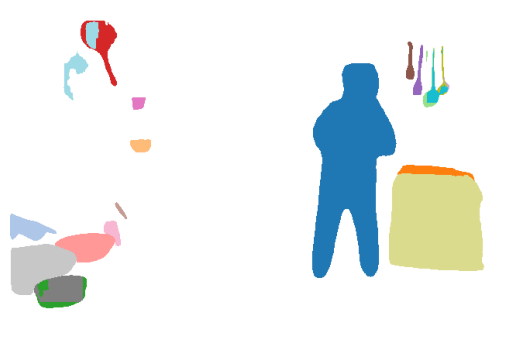

In [ ]:
#Here we evaluate and visualise result from model fine tuned on 1k Data
coco = COCO(coco_val_annotations)
image_ids = coco.getImgIds()
transform = transforms.Compose([transforms.ToTensor()])

# Load fine-tuned model
model, device = load_finetuned_maskrcnn(checkpoint_path="mask_rcnn_mask_predictor_finetuned.pth")

# Run evaluation
compute_mask_metrics(N=1000)

# Visualize results
first_img_id = image_ids[0]
first_img_path = os.path.join(coco_val_images, 
                            coco.loadImgs(first_img_id)[0]['file_name'])
visualize_masks(first_img_path, model, transform, score_threshold=0.5)

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


/var/lit2425/pib/g10/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded fine-tuned model from mask_rcnn_mask_predictor_finetuned_10K_10epochs.pth
Loading and preparing results...
DONE (t=0.19s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=3.97s).
Accumulating evaluation results...
DONE (t=0.57s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.075
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.117
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.036
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.102
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.055
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.084
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1

/tmp/ipykernel_694218/1906275827.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab20', len(pred_classes))


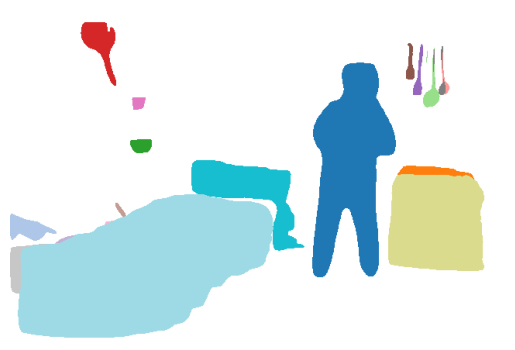

In [ ]:
#Here we evaluate and visualise result from model fine tuned on 10k Data
coco = COCO(coco_val_annotations)
image_ids = coco.getImgIds()
transform = transforms.Compose([transforms.ToTensor()])

# Load fine-tuned model
model, device = load_finetuned_maskrcnn(checkpoint_path="mask_rcnn_mask_predictor_finetuned_10K_10epochs.pth")

# Run evaluation
compute_mask_metrics(N=1000)

# Visualize results
first_img_id = image_ids[0]
first_img_path = os.path.join(coco_val_images, 
                            coco.loadImgs(first_img_id)[0]['file_name'])
visualize_masks(first_img_path, model, transform, score_threshold=0.5)

### Fine tuning with SGD with Momentum

In [ ]:
# Load pretrained Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# Freeze backbone, RPN, and RoI box predictor
for param in model.backbone.parameters():
    param.requires_grad = False
for param in model.rpn.parameters():
    param.requires_grad = False
for param in model.roi_heads.box_predictor.parameters():
    param.requires_grad = False

# Only the RoI segmentation mask predictor will be trained
for param in model.roi_heads.mask_predictor.parameters():
    param.requires_grad = True

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Image preprocessing
transform = transforms.Compose([transforms.ToTensor()])



# Load COCO dataset
coco = COCO(coco_train_annotations)
dataset = COCODataset(coco, coco_train_images, transform, subset_size=1000)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))

# Define optimizer (only trainable parameters)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.000001, momentum=0.9, weight_decay=0.0001) 

# Train for 5 epochs
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, targets in dataloader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.4f}")

# Save fine-tuned model
torch.save(model.state_dict(), "mask_rcnn_mask_predictor_finetuned_SGD.pth")
print("Training complete. Model saved.")

loading annotations into memory...
Done (t=7.47s)
creating index...
index created!
Subset: 991/1000 images have annotations.
Epoch 1/5, Loss: 0.6631
Epoch 2/5, Loss: 0.6651
Epoch 3/5, Loss: 0.6635
Epoch 4/5, Loss: 0.6629
Epoch 5/5, Loss: 0.6650
Training complete. Model saved.


In [30]:


# Define dataset paths
coco_root = "/var/lit2425/pib/g10/CoCo"
coco_train_annotations = f"{coco_root}/annotations/instances_train2017.json"
coco_train_images = f"{coco_root}/train2017"

# Load pretrained Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# Freeze backbone, RPN, and RoI box predictor
for param in model.backbone.parameters():
    param.requires_grad = False
for param in model.rpn.parameters():
    param.requires_grad = False
for param in model.roi_heads.box_predictor.parameters():
    param.requires_grad = False

# Only the RoI segmentation mask predictor will be trained
for param in model.roi_heads.mask_predictor.parameters():
    param.requires_grad = True

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Image preprocessing
transform = transforms.Compose([transforms.ToTensor()])



# Load COCO dataset
coco = COCO(coco_train_annotations)
dataset = COCODataset(coco, coco_train_images, transform, subset_size=1000)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))

# Define optimizer (only trainable parameters)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.000001, momentum=0.9, weight_decay=0.0001) 

# Train for 5 epochs
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, targets in dataloader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.4f}")

# Save fine-tuned model
torch.save(model.state_dict(), "mask_rcnn_mask_predictor_finetuned_SGD.pth")
print("Training complete. Model saved.")

loading annotations into memory...
Done (t=6.85s)
creating index...
index created!
Subset: 994/1000 images have annotations.
Epoch 1/10, Loss: 0.6601
Epoch 2/10, Loss: 0.6587
Epoch 3/10, Loss: 0.6615
Epoch 4/10, Loss: 0.6606
Epoch 5/10, Loss: 0.6645
Epoch 6/10, Loss: 0.6586
Epoch 7/10, Loss: 0.6619
Epoch 8/10, Loss: 0.6591
Epoch 9/10, Loss: 0.6602
Epoch 10/10, Loss: 0.6603
Training complete. Model saved.


loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
Loaded fine-tuned model from mask_rcnn_mask_predictor_finetuned_SGD.pth
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=2.75s).
Accumulating evaluation results...
DONE (t=0.55s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.075
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.117
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.102
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.055
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] =

/tmp/ipykernel_2280824/1906275827.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab20', len(pred_classes))


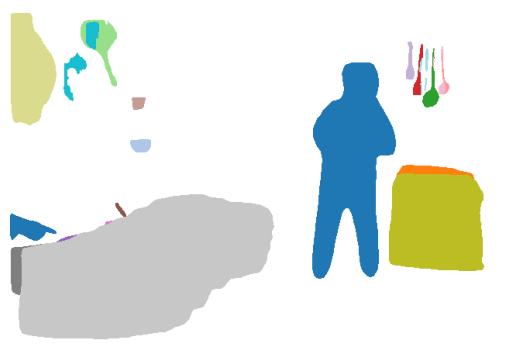

In [36]:


# Initialize
coco = COCO(coco_val_annotations)
image_ids = coco.getImgIds()
# Load fine-tuned model
model, device = load_finetuned_maskrcnn(checkpoint_path="mask_rcnn_mask_predictor_finetuned_SGD.pth")

# Run evaluation
compute_mask_metrics(N=1000)

# Visualize results
first_img_id = image_ids[0]
first_img_path = os.path.join(coco_val_images, 
                            coco.loadImgs(first_img_id)[0]['file_name'])
visualize_masks(first_img_path, model, transform, score_threshold=0.5)

In [ ]:
# Load pretrained Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# Freeze backbone, RPN, and RoI box predictor
for param in model.backbone.parameters():
    param.requires_grad = False
for param in model.rpn.parameters():
    param.requires_grad = False
for param in model.roi_heads.box_predictor.parameters():
    param.requires_grad = False

# Only the RoI segmentation mask predictor will be trained
for param in model.roi_heads.mask_predictor.parameters():
    param.requires_grad = True

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Image preprocessing
transform = transforms.Compose([transforms.ToTensor()])



# Load COCO dataset
coco = COCO(coco_train_annotations)
dataset = COCODataset(coco, coco_train_images, transform, subset_size=1000)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))

# Define optimizer (only trainable parameters)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.000001, momentum=0.9, weight_decay=0.0001) 

# Train for 10 epochs
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, targets in dataloader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.4f}")

# Save fine-tuned model
torch.save(model.state_dict(), "mask_rcnn_mask_predictor_finetuned_SGD_10epochs.pth")
print("Training complete. Model saved.")

loading annotations into memory...
Done (t=7.61s)
creating index...
index created!
Subset: 994/1000 images have annotations.
Epoch 1/10, Loss: 0.6602
Epoch 2/10, Loss: 0.6618
Epoch 3/10, Loss: 0.6614
Epoch 4/10, Loss: 0.6583
Epoch 5/10, Loss: 0.6612
Epoch 6/10, Loss: 0.6581
Epoch 7/10, Loss: 0.6587
Epoch 8/10, Loss: 0.6611
Epoch 9/10, Loss: 0.6625
Epoch 10/10, Loss: 0.6607
Training complete. Model saved.


loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


/var/lit2425/pib/g10/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded fine-tuned model from mask_rcnn_mask_predictor_finetuned_SGD_10epochs.pth
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=5.17s).
Accumulating evaluation results...
DONE (t=0.59s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.075
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.117
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.102
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.055
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.084
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1

/tmp/ipykernel_2339245/1906275827.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab20', len(pred_classes))


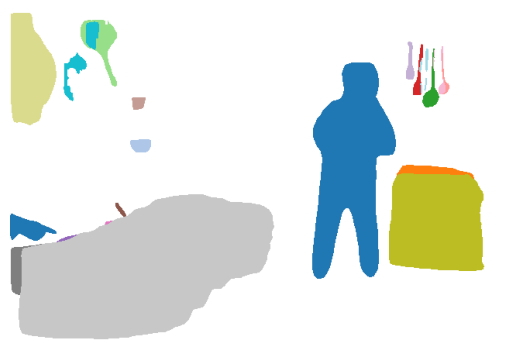

In [29]:


# Initialize
coco = COCO(coco_val_annotations)
image_ids = coco.getImgIds()
# Load fine-tuned model
model, device = load_finetuned_maskrcnn(checkpoint_path="mask_rcnn_mask_predictor_finetuned_SGD_10epochs.pth")

# Run evaluation
compute_mask_metrics(N=1000)

# Visualize results
first_img_id = image_ids[0]
first_img_path = os.path.join(coco_val_images, 
                            coco.loadImgs(first_img_id)[0]['file_name'])
visualize_masks(first_img_path, model, transform, score_threshold=0.5)

/var/lit2425/pib/g10/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/var/lit2425/pib/g10/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded fine-tuned model from mask_rcnn_mask_predictor_finetuned_10K_10epochs.pth


/tmp/ipykernel_694218/1906275827.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab20', len(pred_classes))


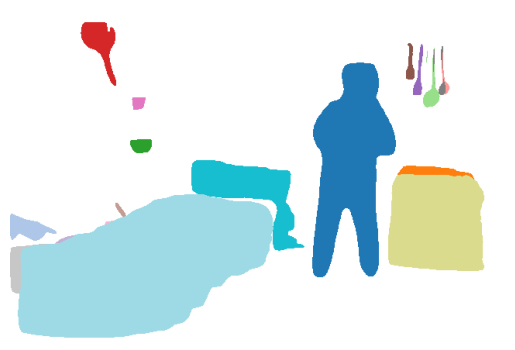

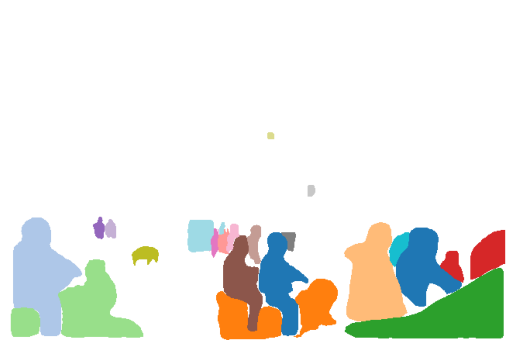

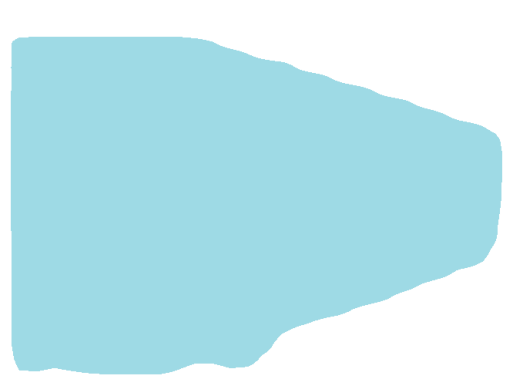

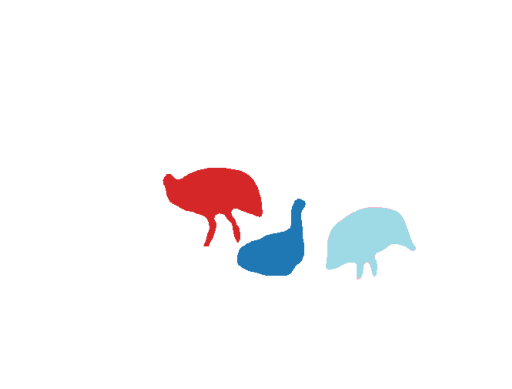

In [22]:
model, device = load_finetuned_maskrcnn(checkpoint_path="mask_rcnn_mask_predictor_finetuned_10K_10epochs.pth")



# Visualize results
first_img_id = image_ids[0]
first_img_path = os.path.join(coco_val_images, 
                            coco.loadImgs(first_img_id)[0]['file_name'])
visualize_masks(first_img_path, model, transform, score_threshold=0.5)

second_img_id = image_ids[10]
second_img_path = os.path.join(coco_val_images, 
                            coco.loadImgs(second_img_id)[0]['file_name'])
visualize_masks(second_img_path, model, transform, score_threshold=0.5)


third_img_id = image_ids[20]
third_img_path = os.path.join(coco_val_images, 
                            coco.loadImgs(third_img_id)[0]['file_name'])
visualize_masks(third_img_path, model, transform, score_threshold=0.5)


fourth_img_id = image_ids[30]
fourth_img_path = os.path.join(coco_val_images, 
                            coco.loadImgs(fourth_img_id)[0]['file_name'])
visualize_masks(fourth_img_path, model, transform, score_threshold=0.5)